# Pricing options from real data by binomial model

# <font color='red'>Important</font>

Before you do anything in this lab please open 
__Anaconda Prompt__ from MenuStart
and type 
__pip install pandas_datareader__
and press __ENTER__. 

If you fail to install it Exercise 1 and all the cells above it won't work. 

### Please select the line below and press __Shift+Enter__

In [46]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt 
from scipy import stats
import pandas_datareader.data as web
from datetime import datetime

## Importing Apple stock prices as DataFrame

In [47]:
start_date = 2018, 4, 12
end_date = 2019, 4, 13
start = datetime(*start_date) #date a year from now
end = datetime(*end_date) #today's date
df_stock = web.DataReader('AAPL', 'iex', start, end) #by using that you can get stock prices from the web
# first parameter is 'AAPL' is a ticker that represents Apple, 
# 'iex' is a The Investors Exchange (IEX) https://iextrading.com/apps/stocks/ from where we get the data
# Example of other tickers are:
# GOOGL for google stock
# FB for facebook 
# MSFT for Microsoft
# Full list can be downloaded from http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download

df_stock.head() # this displayed the header of the dataframe

2y


,open,high,low,close,volume
date,,,,,
2018-04-12,170.8090,172.3752,170.4446,171.5281,22889285
2018-04-13,172.1585,173.2026,171.2424,172.1092,25124255
2018-04-16,172.4048,173.5473,172.2078,173.1829,21578420
2018-04-17,173.8428,176.2526,173.7640,175.5666,26605442
2018-04-18,175.1430,176.1379,174.2270,175.1726,20754538


- __open__ The opening price is the price at which a security first trades upon the opening of an exchange on a trading day.
- __high__ and __low__ The daily high is the highest price reached by a given security or index during a given day, while the daily low is the lowest price reached by a given security or index during a given day. If there has been no price change during the day then the High and Low values will be the same as the previous day’s close.
- __close__ The column "close" contains the closing price on a given day and it is the last price for a tradable instrument at the time the market closes. The closing price will be based on the results of the closing auction or the mid price of the best bid and offer prices at the time the market closes.
- __volume__ This figure represents the cumulative volume for the day i.e. the total number of shares traded during the current day. A dash is used to identify the cumulative volume for some illiquid securities, and means that there has been no reported trades for that particular security (i.e. a cumulative trading volume of zero).


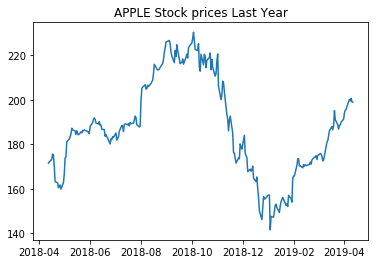

In [48]:
dates = df_stock.index #in order to display dates on the graph we can do as follows
dates = [datetime.strptime(d,'%Y-%m-%d').date() for d in dates]  #we have to convert it to a certain supported format
plt.plot(dates, df_stock["close"])
plt.title("APPLE Stock prices Last Year")
plt.show()

# Estimating volatlity
Here we estimate the volatility $\sigma$ of the APPLE stocks in the last year period. 

Recall that given the column of stock prices $s = \{s_1, s_2, \ldots, s_{251}\}$, 
the estimated volatility can be approximated by
$$\sigma \approx  \sqrt{ \frac{\mbox{Var}(y)}{\delta t}},$$
where $$y = \left\{\ln\left(\frac{s_2}{s_1}\right),\ln\left(\frac{s_3}{s_2}\right), \ldots, \ln\left(\frac{s_{251}}{s_{250}}\right) \right\}$$
and $\mbox{Var}(x) = \frac{1}{n} \sum_{k=1}^n \left(x_i - \frac{1}{n}\sum_{k=1}^n x_i \right)^2$ stands for the variance of $x = \{x_1, x_2, \ldots, x_n\}$. 
You may also want to use the unbiased estimator for the population variance 
$$\mbox{Var}_2(x) = \frac{1}{n-1} \sum_{k=1}^n \left(x_i - \frac{1}{n}\sum_{k=1}^n x_i \right)^2.$$ 

In [49]:
def volatlity(stock, my_ddof = 0):
    dt = 1/stock.size
    current = stock
    shifted = stock.shift(-1)
    shifted = shifted[:-1]
    current = current[:-1]
    delta_logs = np.log(shifted) - np.log(current)
    variance = np.var(delta_logs, ddof = my_ddof)
    return np.sqrt(variance/dt)

In [50]:
apple = df_stock["close"]

apple_vol1 =  volatlity(apple)
apple_vol2 = volatlity(apple, 1)

print(apple_vol1, apple_vol2)

0.30150023134021914 0.3021002323940535


# Importing Option Data

Make sure that you downloaded __options_yahoo.py__ file from Moodle and placed it in the same folder as this notebook. 
Then evalute the cell

In [51]:
from options_yahoo import * #import my script

This is the script that I wrote to allow you to download options data from YahooFinance portal. The function that you wish to use is __yahoo_fin_opts__ that has two string inputs, a stock ticker e.g. 'AAPL', and the date with a strange formatting e.g. 1579219200 (the number of seconds since Thursday, 1 January 1970 until the selected date).
This number can be obtained from here [Link](https://uk.finance.yahoo.com/quote/AAPL/options?p=AAPL&straddle=true) after you select the date from the list. 

By using __options_yahoo__ function we import the prices of options on APPLE stock with maturity in about a year from now. 
We Print the header of this dataframe and print the call prices (y axis) versus strike prices (x axis). 

In [52]:
df_appl_opts = yahoo_fin_opts('AAPL', '1592524800')
df_appl_opts.head()

,strike,call
0,75.0,86.25
1,80.0,120.70
2,85.0,104.00
3,90.0,106.22
4,95.0,76.72


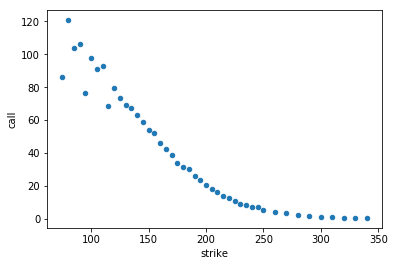

In [53]:
df_appl_opts.plot(kind='scatter', x="strike", y="call")
plt.show()

# Binomial prices versus real-world prices
Now we will price the options by using the binomial tree model. Use the function __binomial_pricer__ written below, also we use the following parameters
- S0 - the current price of Apple stock, obtained from the __df_stock__ dataframe. 
- K - the list of strike prices from the previous exercise,
- sigma, the estimated volatlity,
- r, set to zero, 
- T, set to 1.0, 
- n, set to 251. 
- payoff, call payoff function. 

We produce the graph of call prices in the binomial model and compare it with the real-world prices. 

In [54]:
def binomial_term(S0, K, u, q, n, f, k):
    d = 1/u
    binomial_coeff = stats.binom.pmf(k, n, q)
    ST = S0*u**k*d**(n-k)
    payoff = f(ST, K)
    return binomial_coeff*payoff


def binomial_pricer(S0, K, sigma, r, T, n, payoff):
    k_vals = np.arange(0, n+1)
    dt = T/n
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    q = (np.exp(r*dt)-d)/(u-d)
    binomial_terms = binomial_term(S0, K, u, q, n, payoff, k_vals)
    overall_sum = np.sum(binomial_terms)
    return np.exp(-r*dt*n)*overall_sum

def call(ST, K):
    return np.maximum(ST-K, 0)

In [55]:
S0 = df_stock["close"][-1]
K_vals = df_appl_opts["strike"]
sigma = apple_vol1 
r = 0
T = 1.0
n = 261
binomial_calls = np.array([binomial_pricer(S0, K, sigma, r, T, n, call) for K in K_vals])

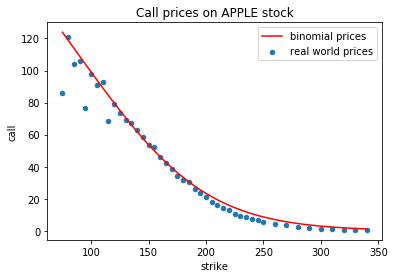

In [56]:
df_appl_opts.plot(kind='scatter', x="strike", y="call", label="real world prices")
plt.plot(K_vals, binomial_calls, 'r', label='binomial prices')
plt.title("Call prices on APPLE stock")
plt.legend()
plt.show()